In [224]:
import geopandas as gp
import rasterio.plot

In [82]:
import rasterio
import rasterstats
import fiona as f
import numpy as np
from matplotlib import pyplot
from pprint import pprint
from stac import STAC

In [2]:
from rasterstats import zonal_stats, point_query

In [3]:
stac_client = STAC('http://brazildatacube.dpi.inpe.br/bdc-stac/0.8.0/')

In [4]:
collection = stac_client.collection('C4_64_16D_MED')

In [5]:
items = collection.get_items()

In [64]:
pprint(items.features[0])

{'assets': {'blue': {'href': 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/C4_64_16D_MED/083100/2019-12-19_2019-12-31/C4_64_16D_MED_083100_2019-12-19_2019-12-31_blue.tif'},
            'cnc': {'href': 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/C4_64_16D_MED/083100/2019-12-19_2019-12-31/C4_64_16D_MED_083100_2019-12-19_2019-12-31_cnc.tif'},
            'evi': {'href': 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/C4_64_16D_MED/083100/2019-12-19_2019-12-31/C4_64_16D_MED_083100_2019-12-19_2019-12-31_evi.tif'},
            'green': {'href': 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/C4_64_16D_MED/083100/2019-12-19_2019-12-31/C4_64_16D_MED_083100_2019-12-19_2019-12-31_green.tif'},
            'ndvi': {'href': 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/C4_64_16D_MED/083100/2019-12-19_2019-12-31/C4_64_16D_MED_083100_2019-12-19_2019-12-31_ndvi.tif'},
            'nir': {'href': 'http://brazildatacube.dpi.inpe.br/Repository/Mosaic/C4_64_16D_MED/083100/

In [132]:
red = items.features[0].assets['red'].download()
green = items.features[0].assets['green'].download()
blue = items.features[0].assets['blue'].download()
ndvi = items.features[0].assets['ndvi'].download()

In [7]:
rasterio.open(red).read(1)

array([[413, 418, 420, ..., 817, 729, 706],
       [420, 423, 422, ..., 831, 761, 702],
       [423, 414, 406, ..., 853, 786, 698],
       ...,
       [774, 808, 703, ..., 717, 717, 629],
       [768, 775, 672, ..., 755, 721, 661],
       [685, 627, 586, ..., 745, 714, 669]], dtype=int16)

In [65]:
red

'C4_64_16D_MED_083100_2019-12-19_2019-12-31_red.tif'

In [200]:
r = rasterio.open(red).read(1)
g = rasterio.open(green).read(1)
b = rasterio.open(blue).read(1)
vi = rasterio.open(ndvi)

In [40]:
r.max()

4369

In [168]:
with rasterio.open(red) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

# Print GeoJSON shapes to stdout.
pprint(geom.get("type"))

'Polygon'


In [41]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

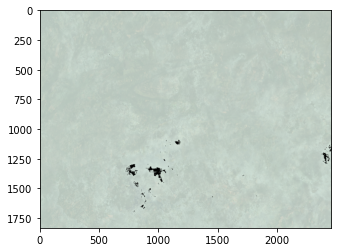

In [49]:
rgb = np.dstack((normalize(r), normalize(g), normalize(b)))
pyplot.imshow(rgb)

In [220]:
shp = gp.read_file('data/test/polygons/polygons.shp')

In [232]:
shp = shp.to_crs(vi.crs.to_dict())

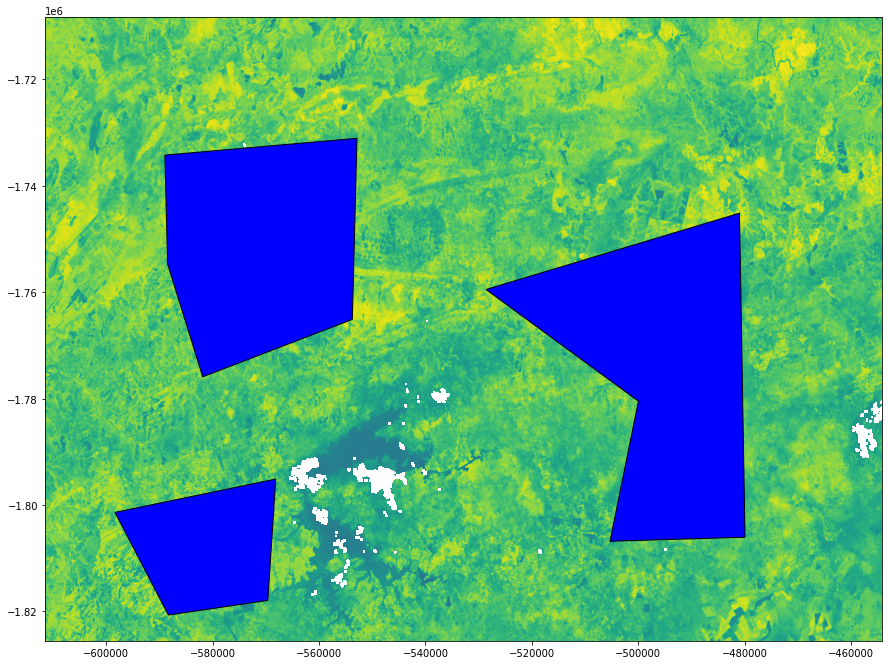

In [240]:
fig, ax = pyplot.subplots(figsize=(15,15))
rasterio.plot.show(vi,ax=ax)
shp.plot(ax=ax,facecolor="blue", edgecolor="black")

In [80]:
def mean(x):
    return np.ma.mean(x)

In [245]:
stats = zonal_stats(
    'data/test/polygons/polygons.shp',
    red,
    stats="count",
    add_stats={
        'mean': mean
    },
    band=1,
    geojson_out=True
)
pprint(stats)

[{'geometry': {'coordinates': [[(-56.01824706114791, -14.375444426917133),
                                (-55.64863470267903, -14.356586653525866),
                                (-55.665606698731175, -14.635681699716653),
                                (-55.95601640895673, -14.718655902638234),
                                (-56.01824706114791, -14.543278610099431),
                                (-56.01824706114791, -14.375444426917133)]],
               'type': 'Polygon'},
  'id': '0',
  'properties': OrderedDict([('id', 1),
                             ('name', 'test1'),
                             ('count', 0),
                             ('mean', masked)]),
  'type': 'Feature'},
 {'geometry': {'coordinates': [[(-55.407255203270786, -14.594194598255859),
                                (-54.91695309509778, -14.4848195125865),
                                (-54.91883887243691, -14.984550507455134),
                                (-55.17907614523643, -14.986436284794262)

In [243]:
with rasterio.open(ndvi) as src:
    affine = src.transform
    array = src.read(1)

stats = zonal_stats(
    shp,
    ndvi,
    stats=["min","max"]
)

pprint(stats)

[{'max': 9424.0, 'min': 2627.0},
 {'max': 9033.0, 'min': 2736.0},
 {'max': 8774.0, 'min': 3058.0}]


In [246]:
shp = gp.read_file('data/test/polygons/polygons.geojson')

In [247]:
shp = shp.to_crs(vi.crs.to_dict())

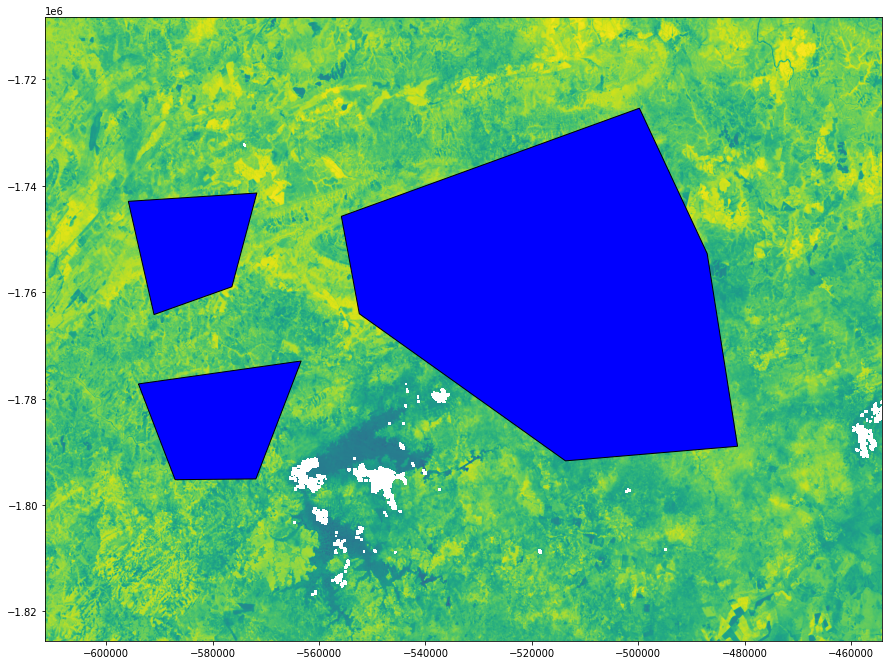

In [248]:
fig, ax = pyplot.subplots(figsize=(15,15))
rasterio.plot.show(vi,ax=ax)
shp.plot(ax=ax,facecolor="blue", edgecolor="black")

In [249]:
zs = zonal_stats(shp, ndvi, stats="count mean", all_touched=True)
pprint(zs)

[{'count': 92941, 'mean': 6949.405321655674},
 {'count': 112637, 'mean': 6155.987162300133},
 {'count': 791129, 'mean': 6409.143202941619}]


In [250]:
shp = gp.read_file('data/test/points/points.geojson')

DriverError: data/test/points/points.geojson: No such file or directory

In [ ]:
shp = shp.to_crs(vi.crs.to_dict())

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,15))
rasterio.plot.show(vi,ax=ax)
shp.plot(ax=ax,facecolor="blue", edgecolor="black")

In [125]:
pts = point_query('data/test/points/points.shp', red, band=1)
pts

[None, None, None]